# Description
This script aims to re-implement the idea of Zhong, C., Batty, M., Manley, E., Wang, J., Wang, Z., Chen, F., & Schmitt, G. (2016). Variability in regularity: Mining temporal mobility patterns in London, Singapore and Beijing using smart-card data. PloS one, 11(2), e0149222. 

## Generate temporal interactions between stations

In [1]:
import numpy as np
import pandas as pd
import csv
import time,datetime
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
from sklearn.externals import joblib
from scipy import spatial
%matplotlib inline

In [42]:
# Loading all the data， returned with a textfile parser
ds_0319_parser=pd.read_csv('data_processed/20120319 Data1.csv',low_memory=False, iterator=True)
ds_0320_parser=pd.read_csv('data_processed/20120320 Data1.csv',low_memory=False, iterator=True)
ds_0321_parser=pd.read_csv('data_processed/20120321 Data1.csv',low_memory=False, iterator=True)
ds_0322_parser=pd.read_csv('data_processed/20120322 Data1.csv',low_memory=False, iterator=True)
ds_0323_parser=pd.read_csv('data_processed/20120323 Data1.csv',low_memory=False, iterator=True)
ds_0324_parser=pd.read_csv('data_processed/20120324 Data1.csv',low_memory=False, iterator=True)
ds_0325_parser=pd.read_csv('data_processed/20120325 Data1.csv',low_memory=False, iterator=True)

In [23]:
chunk_test=ds_0319_parser.get_chunk(1000)
print(chunk_test.describe())
print(chunk_test.head())

         journey_id       card_id  riding_distance  riding_time   transfer
count  1.000000e+01  1.000000e+01        10.000000    10.000000  10.000000
mean   1.043456e+11  2.000069e+15         2.780000     9.545000   0.400000
std    6.411305e+06  3.476435e+10         2.636412     6.820121   0.699206
min    1.043365e+11  2.000011e+15         0.400000     1.267000   0.000000
25%    1.043399e+11  2.000045e+15         0.925000     5.020750   0.000000
50%    1.043475e+11  2.000077e+15         1.650000     7.308000   0.000000
75%    1.043497e+11  2.000084e+15         4.475000    14.425250   0.750000
max    1.043561e+11  2.000137e+15         7.400000    22.817000   2.000000
        journey_id           card_id passenger_type mode bus_line direction  \
2000  104350282865  2000072392450800  Child/Student  Bus   965            1   
2001  104351775555  2000010612941000  Child/Student  Bus   76             1   
2002  104347778573  2000042149691000  Child/Student  Bus   187            0   
2003  104

In [44]:
stops1=ds_0319['boarding_stop'].append(ds_0319['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops1.drop_duplicates().shape[0])
stops2=ds_0320['boarding_stop'].append(ds_0320['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops2.drop_duplicates().shape[0])
stops3=ds_0321['boarding_stop'].append(ds_0321['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops3.drop_duplicates().shape[0])
stops4=ds_0322['boarding_stop'].append(ds_0322['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops4.drop_duplicates().shape[0])
stops5=ds_0323['boarding_stop'].append(ds_0323['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops5.drop_duplicates().shape[0])
stops6=ds_0324['boarding_stop'].append(ds_0324['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops6.drop_duplicates().shape[0])
stops7=ds_0325['boarding_stop'].append(ds_0325['alighting_stop'])                                        
print('Total stops number after removing duplicates:',stops7.drop_duplicates().shape[0])
stops=stops1.append([stops2,stops3,stops4,stops5,stops6,stops7])
idx=stops.duplicated()
stops=stops[~idx]
print('Total stops in 7days:',stops.shape[0])
del stops1,stops2,stops3,stops4,stops5,stops6,stops7,idx

Total stops number after removing duplicates: 4679
Total stops number after removing duplicates: 4683
Total stops number after removing duplicates: 4681
Total stops number after removing duplicates: 4684
Total stops number after removing duplicates: 4686
Total stops number after removing duplicates: 4702
Total stops number after removing duplicates: 4604
Total stops in 7days: 4735


In [52]:
# We need to map the stations into a different number
stops_dict={}
counter=1
for stop in tqdm_notebook(stops):
    stops_dict[stop]=counter
    counter+=1

In [67]:
# Write dict to csv
with open('StopsDict.csv','w',newline='') as file:
    writer=csv.writer(file)
    for i in stops_dict.items():
        writer.writerow(i)
    

In [2]:
# Load the dict we generate and number the value to sations
stops_dict_csv=pd.read_csv('StopsDict.csv')
stops_dict=dict()
i=0
for i in range(len(stops_dict_csv)):
    stops_dict.setdefault(stops_dict_csv['Stops'][i],stops_dict_csv['Number'][i])
del stops_dict_csv

In [10]:
joblib.dump(stops_dict,'StopDict.sav')
stops_dict

{'STN Ang Mo Kio': 1,
 'STN Segar': 2,
 'STN Pasir Ris': 3,
 'STN Yew Tee': 4,
 '80101': 5,
 '41079': 6,
 'STN Yishun': 7,
 '59009': 8,
 '42029': 9,
 '43499': 10,
 '84359': 11,
 'STN Serangoon': 12,
 '21199': 13,
 '70241': 14,
 '13089': 15,
 '54221': 16,
 'STN Clementi': 17,
 '28519': 18,
 '45421': 19,
 '67219': 20,
 '52509': 21,
 '41041': 22,
 '59089': 23,
 '64031': 24,
 '53389': 25,
 '43341': 26,
 '12129': 27,
 '76399': 28,
 'STN Sembawang': 29,
 '66059': 30,
 '64619': 31,
 '84349': 32,
 '19089': 33,
 'STN Bartley': 34,
 '62071': 35,
 '27361': 36,
 '14199': 37,
 'STN Admiralty': 38,
 '44201': 39,
 '46461': 40,
 '20299': 41,
 '46391': 42,
 '1329': 43,
 '66009': 44,
 '53051': 45,
 '46071': 46,
 '72069': 47,
 '22009': 48,
 '21619': 49,
 '70221': 50,
 '45321': 51,
 '51071': 52,
 '27391': 53,
 '65161': 54,
 '76059': 55,
 '54439': 56,
 '44009': 57,
 '28329': 58,
 '84039': 59,
 '28281': 60,
 '60159': 61,
 'STN Outram Park': 62,
 '46129': 63,
 '43349': 64,
 '10009': 65,
 '43701': 66,
 '18111

## Calculate the correlations under different time slices

In [61]:
# Sort the time into different time intervals
# Firstly, convert the time slice into timestamps
test='2012-03-19 12:45:00.980'
testS=time.strptime(test[:-4],'%Y-%m-%d %H:%M:%S')
print(testS)
print(time.mktime(testS))
chunk['boarding_time']=chunk['boarding_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
chunk['boarding_time']

time.struct_time(tm_year=2012, tm_mon=3, tm_mday=19, tm_hour=12, tm_min=45, tm_sec=0, tm_wday=0, tm_yday=79, tm_isdst=-1)
1332132300.0


0        1.332138e+09
1        1.332147e+09
2        1.332112e+09
3        1.332146e+09
4        1.332154e+09
5        1.332141e+09
6        1.332113e+09
7        1.332147e+09
8        1.332145e+09
9        1.332138e+09
10       1.332145e+09
11       1.332111e+09
12       1.332111e+09
13       1.332148e+09
14       1.332145e+09
15       1.332144e+09
16       1.332141e+09
17       1.332163e+09
18       1.332107e+09
19       1.332147e+09
20       1.332113e+09
21       1.332130e+09
22       1.332136e+09
23       1.332153e+09
24       1.332140e+09
25       1.332137e+09
26       1.332141e+09
27       1.332148e+09
28       1.332143e+09
29       1.332165e+09
             ...     
99970    1.332117e+09
99971    1.332155e+09
99972    1.332157e+09
99973    1.332116e+09
99974    1.332110e+09
99975    1.332111e+09
99976    1.332115e+09
99977    1.332112e+09
99978    1.332118e+09
99979    1.332172e+09
99980    1.332121e+09
99981    1.332148e+09
99982    1.332116e+09
99983    1.332165e+09
99984    1

In [3]:
# Timestamps range
ts_0319_s=int(time.mktime(time.strptime('2012-03-19 00:00:00','%Y-%m-%d %H:%M:%S')))
ts_0319_e=int(time.mktime(time.strptime('2012-03-19 23:59:59','%Y-%m-%d %H:%M:%S')))
ts_0320_s=time.mktime(time.strptime('2012-03-20 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0320_e=time.mktime(time.strptime('2012-03-20 23:59:59','%Y-%m-%d %H:%M:%S'))
ts_0321_s=time.mktime(time.strptime('2012-03-21 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0321_e=time.mktime(time.strptime('2012-03-21 23:59:59','%Y-%m-%d %H:%M:%S'))
ts_0322_s=time.mktime(time.strptime('2012-03-22 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0322_e=time.mktime(time.strptime('2012-03-22 23:59:59','%Y-%m-%d %H:%M:%S'))
ts_0323_s=time.mktime(time.strptime('2012-03-23 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0323_e=time.mktime(time.strptime('2012-03-23 23:59:59','%Y-%m-%d %H:%M:%S'))
ts_0324_s=time.mktime(time.strptime('2012-03-24 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0324_e=time.mktime(time.strptime('2012-03-24 23:59:59','%Y-%m-%d %H:%M:%S'))
ts_0325_s=time.mktime(time.strptime('2012-03-25 00:00:00','%Y-%m-%d %H:%M:%S'))
ts_0325_e=time.mktime(time.strptime('2012-03-25 23:59:59','%Y-%m-%d %H:%M:%S'))
print(ts_0319_e-ts_0319_s)
print(ts_0320_e-ts_0320_s)
print(ts_0321_e-ts_0321_s)
print(ts_0322_e-ts_0322_s)
print(ts_0323_e-ts_0323_s)
print(ts_0324_e-ts_0324_s)
print(ts_0325_e-ts_0325_s)

86399
86399.0
86399.0
86399.0
86399.0
86399.0
86399.0


In [4]:
def isInRange(target,start,end):
    return start<target<end

def getTimeIndex(target,startTimeStamp,endTimeStamp,timeIntervalSize):
    timeIntervals=np.linspace(startTimeStamp,endTimeStamp,timeIntervalSize+1)
    for i in range(len(timeIntervals)-1):
        if isInRange(target,timeIntervals[i],timeIntervals[i+1]):
            return i+1
    return -1 # if not in range

In [72]:
# Build feature dict for all stations
featureMat_0319=dict()
for value in stops_dict.values():
    featureMat_0319[str(value)]=np.zeros((2*len(stops_dict),timeIntervalSize))

In [84]:
%%time
# Convert timestamps with stops index
counter=1
timeIntervalSize=24
ds_0319_parser=pd.read_csv('data_processed/20120319 Data1.csv',low_memory=False, iterator=True)
loop=True
while loop:
    try:        
        chunk=ds_0319_parser.get_chunk(chunkSize)
        chunk['boarding_stop']=chunk['boarding_stop'].apply(lambda x:stops_dict[x])
        chunk['alighting_stop']=chunk['alighting_stop'].apply(lambda x:stops_dict[x])
        chunk['boarding_time']=chunk['boarding_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
        chunk['alighting_time']=chunk['alighting_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
        chunk['boarding_timeIdx']=chunk['boarding_time'].apply(lambda x:getTimeIndex(int(x),ts_0319_s,ts_0319_e,timeIntervalSize))
        chunk['alighting_timeIdx']=chunk['alighting_time'].apply(lambda x:getTimeIndex(int(x),ts_0319_s,ts_0319_e,timeIntervalSize))
        for index,row in chunk.iterrows():
            featureMat_0319[str(row['boarding_stop'])][len(stops_dict)+row['boarding_stop']-1][row['boarding_timeIdx']-1]+=1 #inflow
            featureMat_0319[str(row['boarding_stop'])][row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 #outflow
            featureMat_0319[str(row['alighting_stop'])][len(stops_dict)+row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 # Destination inflow if no tranfer
        print('No.',counter*chunkSize)
        counter+=1
    except StopIteration:
        print("Iteration Stop!")
        loop=False
        break

No. 100000
No. 200000
No. 300000
No. 400000
No. 500000
No. 600000
No. 700000
No. 800000
No. 900000
No. 1000000
No. 1100000
No. 1200000
No. 1300000
No. 1400000
No. 1500000
No. 1600000
No. 1700000
No. 1800000
No. 1900000
No. 2000000
No. 2100000
No. 2200000
No. 2300000
No. 2400000
No. 2500000
No. 2600000
No. 2700000
No. 2800000
No. 2900000
No. 3000000
No. 3100000
No. 3200000
No. 3300000
No. 3400000
No. 3500000
No. 3600000
No. 3700000
No. 3800000
No. 3900000
No. 4000000
No. 4100000
No. 4200000
No. 4300000
No. 4400000
No. 4500000
No. 4600000
No. 4700000
No. 4800000
No. 4900000
No. 5000000
No. 5100000
No. 5200000
No. 5300000
No. 5400000
Iteration Stop!
Wall time: 53min 3s


In [98]:
%%time
joblib.dump(featureMat_0319,'featureMat_0319.sav')

Wall time: 57.2 s


['featureMat_0319.sav']

In [99]:
import sys
print(sys.getsizeof(featureMat_0319))

147560


In [100]:
%%time
featureMat_0320=dict()
timeIntervalSize=24
for value in stops_dict.values():
    featureMat_0320[str(value)]=np.zeros((2*len(stops_dict),timeIntervalSize))
    
counter=1
ds_0320_parser=pd.read_csv('data_processed/20120320 Data1.csv',low_memory=False, iterator=True)
loop=True
while loop:
    try:        
        chunk=ds_0320_parser.get_chunk(chunkSize)
        chunk['boarding_stop']=chunk['boarding_stop'].apply(lambda x:stops_dict[x])
        chunk['alighting_stop']=chunk['alighting_stop'].apply(lambda x:stops_dict[x])
        chunk['boarding_time']=chunk['boarding_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
        chunk['alighting_time']=chunk['alighting_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
        chunk['boarding_timeIdx']=chunk['boarding_time'].apply(lambda x:getTimeIndex(int(x),ts_0320_s,ts_0320_e,timeIntervalSize))
        chunk['alighting_timeIdx']=chunk['alighting_time'].apply(lambda x:getTimeIndex(int(x),ts_0320_s,ts_0320_e,timeIntervalSize))
        for index,row in chunk.iterrows():
            featureMat_0320[str(row['boarding_stop'])][len(stops_dict)+row['boarding_stop']-1][row['boarding_timeIdx']-1]+=1 #inflow
            featureMat_0320[str(row['boarding_stop'])][row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 #outflow
            featureMat_0320[str(row['alighting_stop'])][len(stops_dict)+row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 # Destination inflow if no tranfer
        print('No.',counter*chunkSize)
        counter+=1
    except StopIteration:
        print("Iteration Stop!")
        loop=False
        break
        
joblib.dump(featureMat_0320,'featureMat_0320.sav')

No. 100000
No. 200000
No. 300000
No. 400000
No. 500000
No. 600000
No. 700000
No. 800000
No. 900000
No. 1000000
No. 1100000
No. 1200000
No. 1300000
No. 1400000
No. 1500000
No. 1600000
No. 1700000
No. 1800000
No. 1900000
No. 2000000
No. 2100000
No. 2200000
No. 2300000
No. 2400000
No. 2500000
No. 2600000
No. 2700000
No. 2800000
No. 2900000
No. 3000000
No. 3100000
No. 3200000
No. 3300000
No. 3400000
No. 3500000
No. 3600000
No. 3700000
No. 3800000
No. 3900000
No. 4000000
No. 4100000
No. 4200000
No. 4300000
No. 4400000
No. 4500000
No. 4600000
No. 4700000
No. 4800000
No. 4900000
No. 5000000
No. 5100000
No. 5200000
No. 5300000
No. 5400000
No. 5500000
Iteration Stop!
Wall time: 58min 1s


In [105]:
print(np.corrcoef(featureMat_0319['1'],featureMat_0320['1']))

E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 1.         0.50327299 ...        nan        nan        nan]
 [       nan 0.50327299 1.         ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [106]:
print(np.corrcoef(featureMat_0319['1']))

E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 1.         0.50327299 ...        nan        nan        nan]
 [       nan 0.50327299 1.         ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [5]:
def stationGetCorSameTime(stationMat1,stationMat2,interval): #with 2n*Timeintervalsize
    covResults=[]
    for i in range(interval):
        tmp=spatial.distance.cosine(stationMat1[:,i],stationMat2[:,i])
        if np.isnan(tmp):
            tmp=0
        covResults.append(np.square(1-tmp))
    return covResults,np.mean(covResults)

def getAllStationsCorSameDay(featureMat1,featureMat2,interval):
    varResultsRawDict=dict()
    varResultsMeanList=[]
    for key in tqdm_notebook(stops_dict.keys(),desc='Be'):
        keySta=str(stops_dict[key])
        covResults,covMeanResults=stationGetCorSameTime(featureMat1[keySta],featureMat2[keySta],interval)
        varResultsMeanList.append(covMeanResults)
        varResultsRawDict[key]=covResults
    return varResultsRawDict,varResultsMeanList,np.mean(varResultsMeanList)
    

In [27]:
%%time
#var1,var_19_20=stationGetCorSameTime(featureMat_0319['2'],featureMat_0320['2'])
#print(var1)
#np.average(var1)
#print(var_19_20)
_,varl,varlM=getAllStationsCorSameDay(featureMat_0319,featureMat_0320)
print(varlM)

E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))



0.951721361680802
Wall time: 2min 8s


In [25]:
varl.desribe()

AttributeError: 'list' object has no attribute 'desribe'

{'boxes': [<matplotlib.lines.Line2D at 0x642b0898>],
 'caps': [<matplotlib.lines.Line2D at 0x7eeccf60>,
 'fliers': [<matplotlib.lines.Line2D at 0x729f3a20>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x72a00940>],
 'whiskers': [<matplotlib.lines.Line2D at 0x642b0470>,
  <matplotlib.lines.Line2D at 0x7eeba780>]}

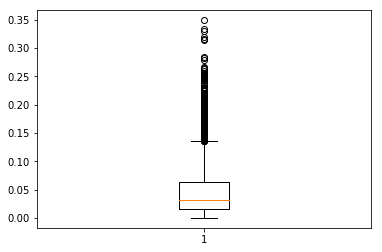

In [30]:
plt.boxplot([1 - e for e in varl])

In [32]:
variability=dict()
variability['24']=varl
variability

{'24': [0.9984734789295352,
  0.9967377708480646,
  0.9996647323630872,
  0.9988763117703218,
  0.9901873358645267,
  0.9531951067369094,
  0.9992593672041705,
  0.967375267460489,
  0.9733457585409528,
  0.9937659636218689,
  0.9809303771952979,
  0.9979096557205677,
  0.8559310340205842,
  0.9523829667766831,
  0.9804225416349243,
  0.9856108934794049,
  0.996893243911801,
  0.9956438141384935,
  0.9937313271121838,
  0.9710148441383337,
  0.9769675426307763,
  0.9913991098035927,
  0.8724764141930544,
  0.9695386390098713,
  0.987606023485674,
  0.9770538779849879,
  0.9403295071813794,
  0.969396771324802,
  0.9991919773132577,
  0.9874910614735731,
  0.990452800516028,
  0.9884490203322827,
  0.9927782271544959,
  0.9769020723965095,
  0.9370190586743611,
  0.9926869490855322,
  0.9492576520368967,
  0.9994017503652906,
  0.9805974793918618,
  0.9725662776710445,
  0.9775796494745915,
  0.9888042537463685,
  0.992957021794577,
  0.9874553246483675,
  0.9876115333881783,
  0.984892


0320 No. 200000
0320 No. 400000
0320 No. 600000
0320 No. 800000
0320 No. 1000000
0320 No. 1200000
0320 No. 1400000
0320 No. 1600000
0320 No. 1800000
0320 No. 2000000
0320 No. 2200000
0320 No. 2400000
0320 No. 2600000
0320 No. 2800000
0320 No. 3000000
0320 No. 3200000
0320 No. 3400000
0320 No. 3600000
0320 No. 3800000
0320 No. 4000000
0320 No. 4200000
0320 No. 4400000
0320 No. 4600000
0320 No. 4800000
0320 No. 5000000
0320 No. 5200000
0320 No. 5400000
0320 No. 5600000
Iteration Stop!
0319 No. 200000
0319 No. 400000
0319 No. 600000
0319 No. 800000
0319 No. 1000000
0319 No. 1200000
0319 No. 1400000
0319 No. 1600000
0319 No. 1800000
0319 No. 2000000
0319 No. 2200000
0319 No. 2400000
0319 No. 2600000
0319 No. 2800000
0319 No. 3000000
0319 No. 3200000
0319 No. 3400000
0319 No. 3600000
0319 No. 3800000
0319 No. 4000000
0319 No. 4200000
0319 No. 4400000
0319 No. 4600000
0319 No. 4800000
0319 No. 5000000
0319 No. 5200000
0319 No. 5400000
Iteration Stop!


E:\Programing\Python_Software\AnacondaSoftware\lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


For time slices: 65 bins mean variability is 0.9144398907680338
0320 No. 200000
0320 No. 400000
0320 No. 600000
0320 No. 800000
0320 No. 1000000
0320 No. 1200000
0320 No. 1400000
0320 No. 1600000
0320 No. 1800000
0320 No. 2000000
0320 No. 2200000
0320 No. 2400000
0320 No. 2600000
0320 No. 2800000
0320 No. 3000000
0320 No. 3200000
0320 No. 3400000
0320 No. 3600000
0320 No. 3800000
0320 No. 4000000
0320 No. 4200000
0320 No. 4400000
0320 No. 4600000
0320 No. 4800000
0320 No. 5000000
0320 No. 5200000
0320 No. 5400000
0320 No. 5600000
Iteration Stop!
0319 No. 200000
0319 No. 400000
0319 No. 600000
0319 No. 800000
0319 No. 1000000
0319 No. 1200000
0319 No. 1400000
0319 No. 1600000
0319 No. 1800000
0319 No. 2000000
0319 No. 2200000
0319 No. 2400000
0319 No. 2600000
0319 No. 2800000
0319 No. 3000000
0319 No. 3200000
0319 No. 3400000
0319 No. 3600000
0319 No. 3800000
0319 No. 4000000
0319 No. 4200000
0319 No. 4400000
0319 No. 4600000
0319 No. 4800000
0319 No. 5000000
0319 No. 5200000
0319 No. 5

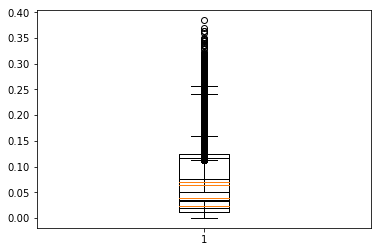

In [11]:
%%time
# Because we only focus on the effect of different time slices variantion in days can be neglected
featureMat_0319_iter=dict()
featureMat_0320_iter=dict()
#timeIntervalSizes=[1,2,4,15,32,48,72,96,180,360,720,1440]
timeIntervalSizes=[65,18,32,60]
chunkSize=200000
# MEMORY ERROR! HAVE TO ITERATE THE TIME INSTEAD OF STATIONS
for interval in tqdm_notebook(timeIntervalSizes,desc='different time intervals'):
    for value in stops_dict.values():
        featureMat_0319_iter[str(value)]=np.zeros((2*len(stops_dict),interval))
        featureMat_0320_iter[str(value)]=np.zeros((2*len(stops_dict),interval))
        
    counter=1
    ds_0320_parser=pd.read_csv('data_processed/20120320 Data1.csv',low_memory=False, iterator=True)
    loop=True
    while loop:
        try:        
            chunk=ds_0320_parser.get_chunk(chunkSize)
            chunk['boarding_stop']=chunk['boarding_stop'].apply(lambda x:stops_dict[x])
            chunk['alighting_stop']=chunk['alighting_stop'].apply(lambda x:stops_dict[x])
            chunk['boarding_time']=chunk['boarding_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
            chunk['alighting_time']=chunk['alighting_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))         
            chunk['boarding_timeIdx']=chunk['boarding_time'].apply(lambda x:getTimeIndex(int(x),ts_0320_s,ts_0320_e,interval))
            chunk['alighting_timeIdx']=chunk['alighting_time'].apply(lambda x:getTimeIndex(int(x),ts_0320_s,ts_0320_e,interval))
            for index,row in chunk.iterrows():
                featureMat_0320_iter[str(row['boarding_stop'])][len(stops_dict)+row['boarding_stop']-1][row['boarding_timeIdx']-1]+=1 #inflow
                featureMat_0320_iter[str(row['boarding_stop'])][row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 #outflow
                featureMat_0320_iter[str(row['alighting_stop'])][len(stops_dict)+row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 # Destination inflow if no tranfer
            print('0320 No.',counter*chunkSize)
            counter+=1
        except StopIteration:
            print("Iteration Stop!")
            loop=False
    
    counter=1
    ds_0319_parser=pd.read_csv('data_processed/20120319 Data1.csv',low_memory=False, iterator=True)
    loop=True
    while loop:
        try:        
            chunk=ds_0319_parser.get_chunk(chunkSize)
            chunk['boarding_stop']=chunk['boarding_stop'].apply(lambda x:stops_dict[x])
            chunk['alighting_stop']=chunk['alighting_stop'].apply(lambda x:stops_dict[x])
            chunk['boarding_time']=chunk['boarding_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))
            chunk['alighting_time']=chunk['alighting_time'].apply(lambda x:time.mktime(time.strptime(x[:-4],'%Y-%m-%d %H:%M:%S')))                
            chunk['boarding_timeIdx']=chunk['boarding_time'].apply(lambda x:getTimeIndex(int(x),ts_0319_s,ts_0319_e,interval))
            chunk['alighting_timeIdx']=chunk['alighting_time'].apply(lambda x:getTimeIndex(int(x),ts_0319_s,ts_0319_e,interval))
            for index,row in chunk.iterrows():
                featureMat_0319_iter[str(row['boarding_stop'])][len(stops_dict)+row['boarding_stop']-1][row['boarding_timeIdx']-1]+=1 #inflow
                featureMat_0319_iter[str(row['boarding_stop'])][row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 #outflow
                featureMat_0319_iter[str(row['alighting_stop'])][len(stops_dict)+row['alighting_stop']-1][row['alighting_timeIdx']-1] +=1 # Destination inflow if no tranfer
            print('0319 No.',counter*chunkSize)
            counter+=1
        except StopIteration:
            print("Iteration Stop!")
            loop=False
    _,vari,variM=getAllStationsCorSameDay(featureMat_0319_iter,featureMat_0320_iter,interval)
    print('For time slices:',interval,'bins mean variability is',variM)
    #variability[str(interval)]=vari
    plt.boxplot([1-e for e in vari])
    filename='variability_'+str(interval)+'.asv'
    joblib.dump(vari,filename)

In [7]:
chunk

NameError: name 'chunk' is not defined

['variability_48.asv']

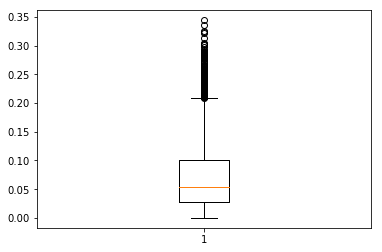

In [9]:
plt.boxplot([1-e for e in vari])
filename='variability_'+str(interval)+'.asv'
joblib.dump(vari,filename)

In [12]:
var2=joblib.load('variability_2.asv')
var4=joblib.load('variability_4.asv')
var15=joblib.load('variability_15.asv')
var18=joblib.load('variability_18.asv')
var24=joblib.load('variability_24.asv')
var32=joblib.load('variability_32.asv')
var48=joblib.load('variability_48.asv')
var60=joblib.load('variability_60.asv')
var65=joblib.load('variability_65.asv')

In [19]:
var2=[1-e for e in var2]
var4=[1-e for e in var4]
var15=[1-e for e in var15]
var18=[1-e for e in var18]
var24=[1-e for e in var24]
var32=[1-e for e in var32]
var48=[1-e for e in var48]
var60=[1-e for e in var60]
var65=[1-e for e in var65]

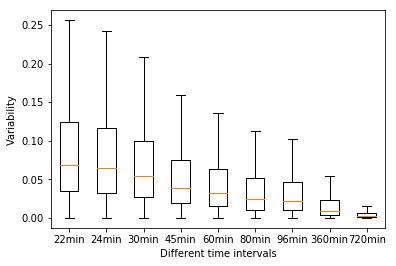

In [24]:
plt.boxplot([var65,var60,var48,var32,var24,var18,var15,var4,var2],labels=['22min','24min','30min','45min','60min','80min','96min','360min','720min'],showfliers=False)
plt.xlabel('Different time intervals')
plt.ylabel('Variability')
#plt.xticks(['22min','24min','30min','45min','60min','80min','96min','360min','720min'])

In [18]:
eq

'var_2=[1-e for e in var2]'